In [1]:
from pathlib import Path
import sys
sys.path.append('../')
from pma_open import *


#My image
# file_path = '../Dropbox Files/hel1.pma'
# image_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame.png"
# image = io.imread(image_path, as_gray=True)

# #Chanel image paths
# CH1_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH1.png"
# CH2_img_path = "../Channel Mapping/hel1_Avg_Frame/hel1_Avg_Frame_CH2.png"

# good_peaks_1,_ = good_peak_finder(CH1_img_path)
# good_peaks_2_new,_ = good_peak_finder(CH2_img_path, sigma=2, block_size=16, scaler_percent=10, boarder=10, max_rad=3)

# # Move good_peaks_1 to CH2 to display full image
# good_peaks_1_CH2 = shift_peaks(good_peaks_1)
# good_peaks_2_CH2 = shift_peaks(good_peaks_2_new)

# # Poly Mapping
# CH1_peaks_10= np.array([[14, 190], [308, 10], [493, 131], [115, 168], [273, 61], [55, 59], [179, 41], [234, 157], [365, 161], [502, 43]])
# CH2_peaks_10 = np.array([[18, 449], [311, 269], [492, 388], [119, 427], [276, 319], [60, 318], [183, 300], [236, 416], [364, 419], [501, 301]])

# params_x_man_10, params_y_man_10 = find_polyfit_params(CH1_peaks_10, CH2_peaks_10, degree=3)
# mapped_peaks_10 = apply_polyfit_params(good_peaks_1, params_x_man_10, params_y_man_10).astype(np.uint16)
# poly_pair_count_tol4_10, poly_pair_arr_CH1_tol4_10, poly_pair_arr_CH2_tol4_10 = find_polyfit_pairs(mapped_peaks_10, good_peaks_1, tolerance=4)


#My image
file_path = "../new files _24_3_25/hel1.pma"
image_path = "../Benchmarking/hel1_Avg/hel1_Avg_Frame.png"
image = io.imread(image_path, as_gray=True)

#Chanel image paths
CH1_img_path = "../Benchmarking/hel1_Avg/hel1_Avg_Frame_CH1.png"
CH2_img_path = "../Benchmarking/hel1_AVg/hel1_Avg_Frame_CH2.png"

good_peaks_1,_ = good_peak_finder(CH1_img_path)
good_peaks_2_new,_ = good_peak_finder(CH2_img_path)

# Move good_peaks_1 to CH2 to display full image
good_peaks_1_CH2 = shift_peaks(good_peaks_1)
good_peaks_2_CH2 = shift_peaks(good_peaks_2_new)

#new coords for CH2:
CH1_peaks_10 = np.array([[18,92], [16,213], [108,43], [106, 176], [210,51], [234, 219], [366,12], [322,192], [478, 106], [502,160]])
CH2_peaks_10_new = np.array([[22,349],[19,470],[111,300],[108,433],[212,307],[234,475],[367,268],[321,448],[476,361],[499,414]])
params_x_man_10_new, params_y_man_10_new = find_polyfit_params(CH1_peaks_10, CH2_peaks_10_new, degree=3)
mapped_peaks_10_new = apply_polyfit_params(good_peaks_1, params_x_man_10_new, params_y_man_10_new).astype(np.uint16)
poly_pair_count_tol4_10_new, poly_pair_arr_CH1_tol4_10_new, poly_pair_arr_CH2_tol4_10_new = find_polyfit_pairs(mapped_peaks_10_new, good_peaks_1, tolerance=3)

#unshift CH2 peaks [+1, +10] to original position
poly_pair_arr_CH2_tol4_10_new_unshift = shift_peaks(poly_pair_arr_CH2_tol4_10_new, [1, 10])

#remove peaks in CH2 that are out of bounds 
poly_pair_arr_CH2_tol4_10_curr = poly_pair_arr_CH2_tol4_10_new_unshift[(poly_pair_arr_CH2_tol4_10_new_unshift[:,1] <= 502) & (poly_pair_arr_CH2_tol4_10_new_unshift[:, 0] <= 502)]
poly_pair_arr_CH1_tol4_10_curr = poly_pair_arr_CH1_tol4_10_new[(poly_pair_arr_CH2_tol4_10_new_unshift[:,1] <= 502) & (poly_pair_arr_CH2_tol4_10_new_unshift[:, 0] <= 502)]


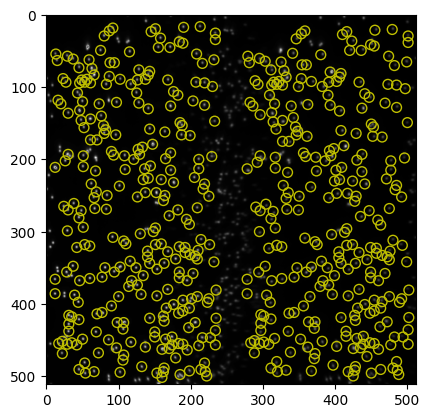

In [2]:
fig, ax = plt.subplots()
plt.imshow(image, cmap='gray')
ax.scatter(poly_pair_arr_CH1_tol4_10_curr[:,1], poly_pair_arr_CH1_tol4_10_curr[:,0], facecolors='none', edgecolors='y', s=50, label='CH1')
ax.scatter(poly_pair_arr_CH2_tol4_10_curr[:,1], poly_pair_arr_CH2_tol4_10_curr[:,0], facecolors='none', edgecolors='y', s=50, label='CH2')
plt.show()

# Calculate Static Global Background. 
#### Static-> Based on the average frame data only
#### Global -> uniform across the frame

In [3]:
y_centres_hel1 = np.concatenate((poly_pair_arr_CH1_tol4_10_curr[:,0],poly_pair_arr_CH2_tol4_10_curr[:,0]))
x_centres_hel1 = np.concatenate((poly_pair_arr_CH1_tol4_10_curr[:,1],poly_pair_arr_CH2_tol4_10_curr[:,1]))
circle_array_new = draw_circle(4, y_centres_hel1,  x_centres_hel1, image.shape[0])

mask_new = (circle_array_new == [255, 255, 0]).all(axis=-1)
if image.ndim == 2:
    image_3d = np.repeat(image[..., np.newaxis], 3, -1)
elif image.ndim==3 and image.shape[2]==3:
    image_3d = image
image_3d[mask_new] = [255, 255, 0]

In [4]:
#in stage 0 we are making sure we are getting the total of all peaks
def static_global_background_0(input_array, radius, y_centre_arr, x_centre_arr):
    all_peaks_intensity = 0
    pixel_count = 0
    #filling in the circle
    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        for i in range(x_centre - radius, x_centre+ radius + 1):
            for j in range(y_centre - radius, y_centre + radius + 1):
                if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                    all_peaks_intensity += int(input_array[i][j][0])
                    pixel_count += 1
        

    return all_peaks_intensity, pixel_count

In [5]:
total_peak_intensity, pixel_count = static_global_background_0(image_3d, 4, y_centres_hel1, x_centres_hel1)
print(total_peak_intensity)
print(pixel_count)

455923
23940


# Testing this with our fake peaks!

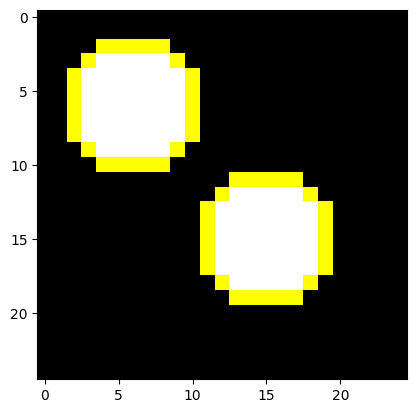

In [6]:
#Demonstates that we are selecting the pixels within the yellow circle outline
def fill_circle(input_array, radius, y_centre_arr, x_centre_arr, colour_fill = [255, 255, 255]):
    #setting background to [0,0,0]
    #filling in the circle
    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        for i in range(x_centre - radius, x_centre + radius + 1):
            for j in range(y_centre - radius, y_centre + radius + 1):
                if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                    input_array[i, j] = colour_fill
    
    return input_array
radius = 4
background_dim= 25
x_cen = np.array([6, 15])
y_cen = np.array([6, 15])
background_array = draw_circle(radius, y_cen, x_cen, background_dim)
circle_array = fill_circle(background_array, radius, y_cen, x_cen)
plt.imshow(circle_array)

In [7]:
total_peak_intensity_circle, pixel_count_circle = static_global_background_0(circle_array, 4, y_cen, x_cen)
print(f"Total peak intensity: {total_peak_intensity_circle}")
print(45*2*255)
print(f"Total arr: {pixel_count_circle}")
print(45*2)

Total peak intensity: 22950
22950
Total arr: 90
90


# This code works so far so we should continue!
#### Add up the entire pixel intensity of the frame
#### Take away the total pixel intensity of the peaks
#### divide by the number of total pixels 512*512
#### this is the number we should take away from every pixel value!

In [8]:
#in stage 1 we should be getting the total value of all pixels in the image (DO NOT USE image_3d)

def static_global_background_1(input_array_w_circle, input_array_no_circle, radius, y_centre_arr, x_centre_arr):
    all_peaks_intensity = 0
    pixel_count = 0
    #filling in the circle
    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        for i in range(x_centre - radius, x_centre+ radius + 1):
            for j in range(y_centre - radius, y_centre + radius + 1):
                if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                    all_peaks_intensity += int(input_array_w_circle[i][j][0])
                    pixel_count += 1
    
    #find the total intensity of all pixels in the background_array
    total_intensity = 0
    for i in range(input_array_no_circle.shape[0]):
        for j in range(input_array_no_circle.shape[1]):
            total_intensity += int(input_array_no_circle[i][j][0])

    return all_peaks_intensity, pixel_count, total_intensity

Total peak intensity: 22950
45*2*255: 22950
Pixel_count_circle1: 90
Total pixel intensity: 35190


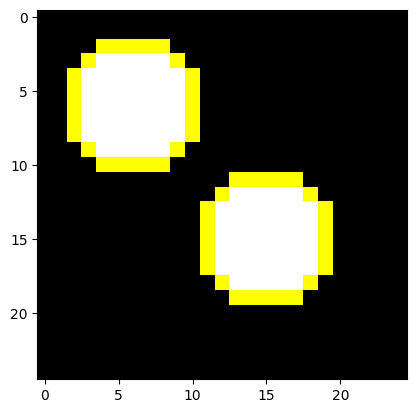

In [9]:
plt.imshow(background_array)
total_peak_intensity_circle1, pixel_count_circle1, total_intensity_circle1= static_global_background_1(background_array, background_array, 4, y_cen, x_cen)
print(f"Total peak intensity: {total_peak_intensity_circle1}")
print(f"45*2*255: {45*2*255}")
print(f"Pixel_count_circle1: {pixel_count_circle1}")
print(F"Total pixel intensity: {total_intensity_circle1}")


In [10]:
num_pix = count_circle(radius=4)
print(type(num_pix))
print(num_pix)

<class 'int'>
45


In [11]:
#At the final stage we should be subtracting total pixel intensity from peak pixel intensity and dividing by the number of pixels in the frame
#then return the number that we get out
def static_global_background(input_array, radius, y_centre_arr, x_centre_arr):
    all_peaks_intensity = 0
    pixel_count = 0
    #filling in the circle
    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        for i in range(x_centre - radius, x_centre+ radius + 1):
            for j in range(y_centre - radius, y_centre + radius + 1):
                if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                    all_peaks_intensity += int(input_array[i][j][0])
                    pixel_count += 1
    
    # by summing the third column of the array we exclude the yellow pixels from being included!
    total_intensity = np.sum(input_array[:, :,2])

    
    num_of_peaks = len(y_centre_arr)
    num_of_peak_pixels = count_circle(radius) * num_of_peaks
    num_of_frame_pixels = input_array.shape[0] * input_array.shape[1]

    #avg_peak_intensity gives the avg intensity of the pixels that are not within the yellow circle
    avg_peak_intensity = (total_intensity-all_peaks_intensity) // (num_of_frame_pixels-num_of_peak_pixels)

    return avg_peak_intensity, total_intensity, num_of_peak_pixels

Here we expect 0 since the background is all black
Avg peak intensity: 0

Total pixel intensity: 22950, expected = 22950
Num of peak pixels: 90, expected=90


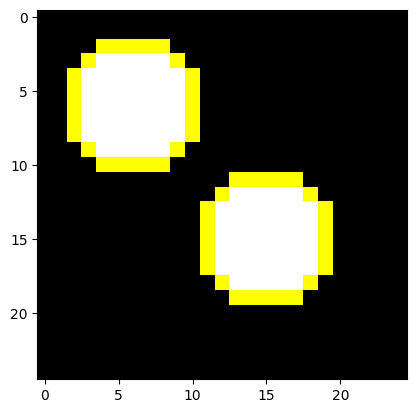

In [12]:
plt.imshow(background_array)
avg_peak_intensity2, total_intensity2, num_of_peak_pixels2= static_global_background(background_array, 4, y_cen, x_cen)

print(f"Here we expect 0 since the background is all black")
print(f"Avg peak intensity: {avg_peak_intensity2}")
print(f"\nTotal pixel intensity: {total_intensity2}, expected = {45*2*255}")
print(f"Num of peak pixels: {num_of_peak_pixels2}, expected={45*2}")

#### The above is a great sign ! we are correctly calculating the total pixel intensity as equal to the predicted value 
# Therefore we can start using this on image_3d

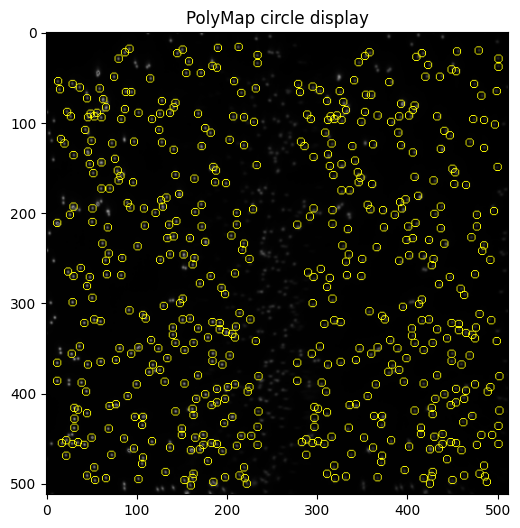

In [13]:
#Should show image_3d so that we know what we are working with.
fig = plt.figure(figsize=(6,6))
ax = fig.subplots()
plt.imshow(image_3d)
plt.title('PolyMap circle display')
plt.show()

In [14]:
y_centres_hel1 = np.concatenate((poly_pair_arr_CH1_tol4_10_curr[:,0],poly_pair_arr_CH2_tol4_10_curr[:,0]))
x_centres_hel1 = np.concatenate((poly_pair_arr_CH1_tol4_10_curr[:,1],poly_pair_arr_CH2_tol4_10_curr[:,1]))
avg_peak_intensity, total_intensity, num_of_peak_pixels= static_global_background(image_3d, 4, y_centres_hel1, x_centres_hel1)
print(f"Avg peak intensity: {avg_peak_intensity}")
print(f"Total pixel intensity: {total_intensity}")
print(f"Num of peak pixels: {num_of_peak_pixels},  expected = {len(y_centres_hel1)*45}")
print(f"\nNumber of peaks: {len(y_centres_hel1)},")
print(f"{len(y_centres_hel1)} * 45: {len(y_centres_hel1)*45}")

Avg peak intensity: 2
Total pixel intensity: 974331
Num of peak pixels: 23940,  expected = 23940

Number of peaks: 532,
532 * 45: 23940


# Since this Static Global function is working well, we should edit it and then put it in pma_open.py

In [15]:
# final function:
# At the final stage we should be subtracting total pixel intensity from peak pixel intensity and dividing by the number of pixels in the frame
# then return the number that we get out


def static_global_background_subtraction_slower(pma_file_path, input_array, radius, y_centre_arr, x_centre_arr):
    frames_data = read_pma(pma_file_path) 
    all_peaks_intensity = 0
    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        for i in range(x_centre - radius, x_centre+ radius + 1):
            for j in range(y_centre - radius, y_centre + radius + 1):
                if (i - x_centre) ** 2 + (j - y_centre) ** 2 < radius ** 2:
                    all_peaks_intensity += int(input_array[j][i][2])
    
    # by summing the third column of the array we exclude the yellow pixels from being included!
    total_intensity = np.sum(input_array[:, :,2])

    
    num_of_peaks = len(y_centre_arr)
    num_of_peak_pixels = count_circle(radius) * num_of_peaks
    num_of_frame_pixels = input_array.shape[0] * input_array.shape[1]

    #avg_peak_intensity gives the avg intensity of the pixels that are not within the yellow circle
    intensity_to_remove = ((total_intensity-all_peaks_intensity) // (num_of_frame_pixels-num_of_peak_pixels))
    corrected_frames_data = []
    for frame in frames_data: #frame is 1D
        frame = frame.astype(np.int16)
        frame = np.clip(frame - intensity_to_remove, 0, 255).astype(np.uint8)
        corrected_frames_data.append(frame)
    return corrected_frames_data

# As for subtracting the avg_peak_intensity from all pixels in all frames

In [16]:
Frames_data = read_pma(file_path)
print(f"Frames_data type: {type(Frames_data)}")
print(f"Frames_data[0] Shape: {Frames_data[0].shape}")
print(f"Frames_data element type: {type(Frames_data[0][0][0])}\n")

corrected_frames_data = static_global_background_subtraction_slower(file_path, image_3d, 4, y_centres_hel1, x_centres_hel1)
print(f"Corrected Frames_data type: {type(corrected_frames_data)}")
print(f"Corrected Frames_data[0] shape: {corrected_frames_data[0].shape}")
print(f"Corrected Frames_data element type: {type(corrected_frames_data[0][0][0])}")

Image Size: 512 x 512
Frames_data type: <class 'list'>
Frames_data[0] Shape: (512, 512)
Frames_data element type: <class 'numpy.uint8'>

Image Size: 512 x 512
Corrected Frames_data type: <class 'list'>
Corrected Frames_data[0] shape: (512, 512)
Corrected Frames_data element type: <class 'numpy.uint8'>


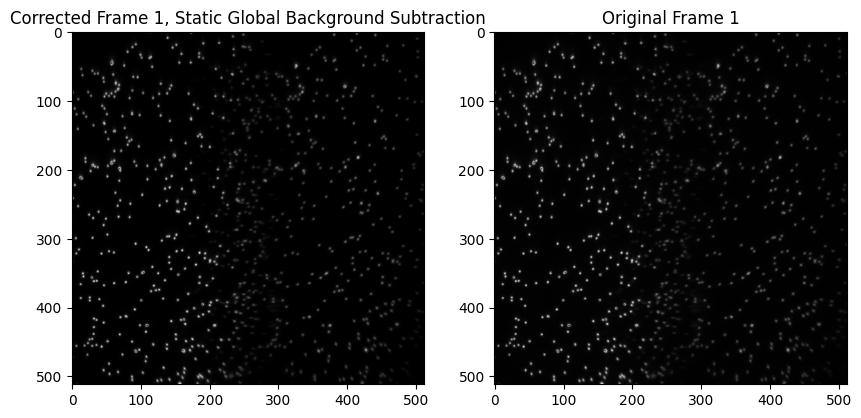

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(corrected_frames_data[0], cmap='gray')
ax[0].set_title('Corrected Frame 1, Static Global Background Subtraction')

ax[1].imshow(Frames_data[0], cmap='gray')
ax[1].set_title('Original Frame 1')
plt.show()

In [18]:
print(poly_pair_arr_CH1_tol4_10_curr[121])
print(poly_pair_arr_CH2_tol4_10_curr[121])

[454  35]
[453 301]


In [19]:
print(Frames_data[0][0][:17])
print(corrected_frames_data[0][0][:17])

print(Frames_data[5][19][230:240])
print(corrected_frames_data[5][19][230:240])

[1 0 1 0 0 0 1 0 0 0 1 0 1 0 1 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[2 3 4 6 7 8 7 4 3 3]
[0 1 2 4 5 6 5 2 1 1]


# Honing In on Peak 121: aka peak 1 in ppt

In [20]:
print(Frames_data[0][454])

[  3   3   4   6  12  25  34  23  10   5   3   3   4   5   5  10  21  43
  51  31  20  24  46  54  29  13  12  20  33  37  24  13  13  30  95 148
  93  25   9   7   9  16  21  19  13   7   5   5   5   5   5   5   5   4
   4   3   3   3   3   2   2   3   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   3   2   2   3   3   4   4   5   5   6   7   7   5
   5   5   4   4   4   4   4   4   4   3   3   3   3   3   3   3   3   3
   3   3   3   3   4   6  12  34 139  28 242  84  20  10   5   4   4   3
   3   3   3   3   4   4   5   6  12  31 113 217 178  61  17  10   6   5
   5   4   4   3   3   3   4   3   3   3   3   3   3   3   4   5   5   6
   6   6   6   7   7   7   6   6   7  11  20  25  21  13  14   9   7  10
  18  43  72  70  39  21  19  23  31  30  20  15  11   8   7   5   4   4
   4   3   4   3   3   3   3   3   3   3   4   6   6   6   5   6   7   7
   7   6   5   5   4   3   3   3   3   3   3   3   3   3   4   6   8   8
   6   5   5   6   7   6   5   4   4   4   4   3   

In [21]:
# hone in on 454, 35 of frame 0
print(corrected_frames_data[0][454])

[  1   1   2   4  10  23  32  21   8   3   1   1   2   3   3   8  19  41
  49  29  18  22  44  52  27  11  10  18  31  35  22  11  11  28  93 146
  91  23   7   5   7  14  19  17  11   5   3   3   3   3   3   3   3   2
   2   1   1   1   1   0   0   1   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   1   0   0   1   1   2   2   3   3   4   5   5   3
   3   3   2   2   2   2   2   2   2   1   1   1   1   1   1   1   1   1
   1   1   1   1   2   4  10  32 137  26 240  82  18   8   3   2   2   1
   1   1   1   1   2   2   3   4  10  29 111 215 176  59  15   8   4   3
   3   2   2   1   1   1   2   1   1   1   1   1   1   1   2   3   3   4
   4   4   4   5   5   5   4   4   5   9  18  23  19  11  12   7   5   8
  16  41  70  68  37  19  17  21  29  28  18  13   9   6   5   3   2   2
   2   1   2   1   1   1   1   1   1   1   2   4   4   4   3   4   5   5
   5   4   3   3   2   1   1   1   1   1   1   1   1   1   2   4   6   6
   4   3   3   4   5   4   3   2   2   2   2   1   

In [22]:
# Frames_data = read_pma(file_path)
print(f"Frames_data type: {type(Frames_data[0])}")
print(f"corrected_frames_data type: {type(corrected_frames_data[0])}")
print(f"Frames_data type: {type(Frames_data[0][0])}")
print(f"corrected_frames_data type: {type(corrected_frames_data[0][0])}")
print(f"Frames_data type: {type(Frames_data[0][0][0])}")
print(f"corrected_frames_data type: {type(corrected_frames_data[0][0][0])}")

Frames_data type: <class 'numpy.ndarray'>
corrected_frames_data type: <class 'numpy.ndarray'>
Frames_data type: <class 'numpy.ndarray'>
corrected_frames_data type: <class 'numpy.ndarray'>
Frames_data type: <class 'numpy.uint8'>
corrected_frames_data type: <class 'numpy.uint8'>


In [23]:
def static_global_background_subtraction_faster(pma_file_path, input_array, radius, y_centre_arr, x_centre_arr):
    frames_data = read_pma(pma_file_path) 
    
    all_peaks_intensity = 0
    height, width, _ = input_array.shape
    y_indices, x_indices = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
    filled_circle_mask = np.zeros((height, width), dtype=bool)

    # by summing the third column of the array we exclude the yellow pixels from being included!
    total_intensity = np.sum(input_array[:, :,2])
    num_of_peaks = len(y_centre_arr)
    num_of_peak_pixels = count_circle(radius) * num_of_peaks
    num_of_frame_pixels = input_array.shape[0] * input_array.shape[1]
    corrected_frames_data = []

    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        mask = (x_indices - x_centre) ** 2 + (y_indices - y_centre) ** 2 < radius ** 2
        filled_circle_mask|= mask
        
    all_peaks_intensity += np.sum(input_array[filled_circle_mask, 2])
    intensity_to_remove = ((total_intensity-all_peaks_intensity) // (num_of_frame_pixels-num_of_peak_pixels))
    
    for frame in frames_data: #frame is 1D
        frame = frame.astype(np.int16)
        frame = np.clip(frame - intensity_to_remove, 0, 255).astype(np.uint8)
        corrected_frames_data.append(frame)

    return corrected_frames_data

In [24]:
# Frames_data = read_pma(file_path)
print(f"Frames_data type: {type(Frames_data)}")
print(f"Frames_data[0] Shape: {Frames_data[0].shape}")
print(f"Frames_data element type: {type(Frames_data[0][0][0])}\n")

corrected_frames_data = static_global_background_subtraction_slower(file_path, image_3d, 4, y_centres_hel1, x_centres_hel1)
print(f"Corrected Frames_data type: {type(corrected_frames_data)}")
print(f"Corrected Frames_data[0] shape: {corrected_frames_data[0].shape}")
print(f"Corrected Frames_data element type: {type(corrected_frames_data[0][0][0])}")

corrected_frames_data_faster = static_global_background_subtraction_faster(file_path, image_3d, 4, y_centres_hel1, x_centres_hel1)
print(f"Corrected Frames_data type: {type(corrected_frames_data_faster)}")
print(f"Corrected Frames_data[0] shape: {corrected_frames_data_faster[0].shape}")
print(f"Corrected Frames_data element type: {type(corrected_frames_data_faster[0][0][0])}")


Frames_data type: <class 'list'>
Frames_data[0] Shape: (512, 512)
Frames_data element type: <class 'numpy.uint8'>

Image Size: 512 x 512
Corrected Frames_data type: <class 'list'>
Corrected Frames_data[0] shape: (512, 512)
Corrected Frames_data element type: <class 'numpy.uint8'>
Image Size: 512 x 512
Corrected Frames_data type: <class 'list'>
Corrected Frames_data[0] shape: (512, 512)
Corrected Frames_data element type: <class 'numpy.uint8'>


In [25]:
print(Frames_data[300][454][31:39])
print(corrected_frames_data[300][454][31:39])
print(corrected_frames_data_faster[300][454][31:39])

print(Frames_data[5][19][230:240])
print(corrected_frames_data[5][19][230:240])
print(corrected_frames_data_faster[5][19][230:240])


[ 4  6 23 55 52 21  5  3]
[ 2  4 21 53 50 19  3  1]
[ 2  4 21 53 50 19  3  1]
[2 3 4 6 7 8 7 4 3 3]
[0 1 2 4 5 6 5 2 1 1]
[0 1 2 4 5 6 5 2 1 1]


In [26]:
# Frames_data = read_pma(file_path)
print(f"Frames_data type: {type(Frames_data[0])}")
print(f"corrected_frames_data type: {type(corrected_frames_data[0])}")
print(f"corrected_frames_data_faster type: {type(corrected_frames_data_faster[0])}\n")
print(f"Frames_data type: {type(Frames_data[0][0])}")
print(f"corrected_frames_data type: {type(corrected_frames_data[0][0])}")
print(f"corrected_frames_data_faster type: {type(corrected_frames_data_faster[0][0])}\n")
print(f"Frames_data type: {type(Frames_data[0][0][0])}")
print(f"corrected_frames_data type: {type(corrected_frames_data[0][0][0])}")

Frames_data type: <class 'numpy.ndarray'>
corrected_frames_data type: <class 'numpy.ndarray'>
corrected_frames_data_faster type: <class 'numpy.ndarray'>

Frames_data type: <class 'numpy.ndarray'>
corrected_frames_data type: <class 'numpy.ndarray'>
corrected_frames_data_faster type: <class 'numpy.ndarray'>

Frames_data type: <class 'numpy.uint8'>
corrected_frames_data type: <class 'numpy.uint8'>


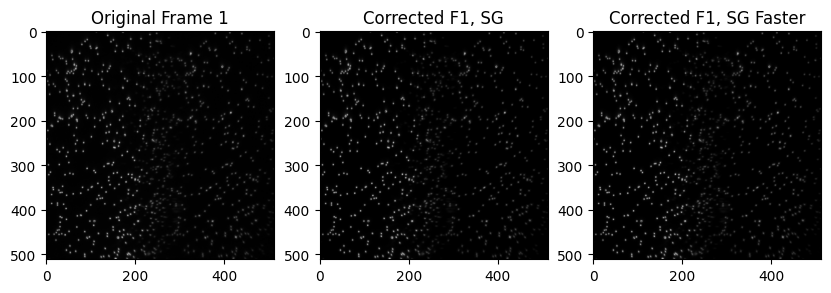

In [27]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(Frames_data[0], cmap='gray')
ax[0].set_title('Original Frame 1')

ax[1].imshow(corrected_frames_data[0], cmap='gray')
ax[1].set_title('Corrected F1, SG')

ax[2].imshow(corrected_frames_data_faster[0], cmap='gray')
ax[2].set_title('Corrected F1, SG Faster')

plt.show()

In [28]:
def static_global_CH_background_subtraction(pma_file_path, input_array, radius, y_centre_arr, x_centre_arr):
    frames_data = read_pma(pma_file_path) 
    
    all_peaks_intensity_CH1 = 0
    all_peaks_intensity_CH2 = 0
    height, width, _ = input_array.shape

    y_indices, x_indices = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
    filled_circle_mask = np.zeros((height, width), dtype=bool)

    # by summing the third column of the array we exclude the yellow pixels from being included!
    total_intensity_CH1 = np.sum(input_array[:, :width//2,2])
    total_intensity_CH2 = np.sum(input_array[:, width//2:,2])

    num_of_peaks = len(y_centre_arr)//2 #this is in each channel
    num_of_peak_pixels = count_circle(radius) * num_of_peaks #each channel
    num_of_frame_pixels = input_array.shape[0] * input_array.shape[1]//2

    corrected_frames_data = []

    for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
        mask = (x_indices - x_centre) ** 2 + (y_indices - y_centre) ** 2 < radius ** 2
        filled_circle_mask|= mask
    
    # split the filled_circle_mask into two channels
    filled_circle_mask_CH1 = filled_circle_mask[:, :width//2]
    filled_circle_mask_CH2 = filled_circle_mask[:, width//2:]
        
    all_peaks_intensity_CH1 += np.sum(input_array[:, :width//2, 2][filled_circle_mask_CH1])
    all_peaks_intensity_CH2 += np.sum(input_array[:, width//2:, 2][filled_circle_mask_CH2])

    intensity_to_remove_CH1 = ((total_intensity_CH1-all_peaks_intensity_CH1) // (num_of_frame_pixels-num_of_peak_pixels))
    intensity_to_remove_CH2 = ((total_intensity_CH2-all_peaks_intensity_CH2) // (num_of_frame_pixels-num_of_peak_pixels))

    
    for frame in frames_data: #frame is 1D
        frame = frame.astype(np.int16)
        frame_CH1 = np.clip(frame[:,:width//2] - intensity_to_remove_CH1, 0, 255).astype(np.uint8)
        frame_CH2 = np.clip(frame[:,width//2:] - intensity_to_remove_CH2, 0, 255).astype(np.uint8)
        frame = np.concatenate((frame_CH1, frame_CH2), axis=1)
        corrected_frames_data.append(frame)

    return corrected_frames_data

In [29]:
Frames_data = read_pma(file_path)
print(f"Frames_data type: {type(Frames_data)}")
print(f"Frames_data[0] Shape: {Frames_data[0].shape}")
print(f"Frames_data element type: {type(Frames_data[0][0][0])}\n")

corrected_frames_data = static_global_background_subtraction_slower(file_path, image_3d, 4, y_centres_hel1, x_centres_hel1)
print(f"Corrected Frames_data type: {type(corrected_frames_data)}")
print(f"Corrected Frames_data[0] shape: {corrected_frames_data[0].shape}")
print(f"Corrected Frames_data element type: {type(corrected_frames_data[0][0][0])}\n")

corrected_frames_data_faster = static_global_background_subtraction_faster(file_path, image_3d, 4, y_centres_hel1, x_centres_hel1)
print(f"Corrected Frames_data type: {type(corrected_frames_data_faster)}")
print(f"Corrected Frames_data[0] shape: {corrected_frames_data_faster[0].shape}")
print(f"Corrected Frames_data element type: {type(corrected_frames_data_faster[0][0][0])}\n")

corrected_frames_data_CH = static_global_CH_background_subtraction(file_path, image_3d, 4, y_centres_hel1, x_centres_hel1)
print(f"Corrected Frames_data type: {type(corrected_frames_data_CH)}")
print(f"Corrected Frames_data[0] shape: {corrected_frames_data_CH[0].shape}")
print(f"Corrected Frames_data element type: {type(corrected_frames_data_CH[0][0][0])}")

Image Size: 512 x 512
Frames_data type: <class 'list'>
Frames_data[0] Shape: (512, 512)
Frames_data element type: <class 'numpy.uint8'>

Image Size: 512 x 512
Corrected Frames_data type: <class 'list'>
Corrected Frames_data[0] shape: (512, 512)
Corrected Frames_data element type: <class 'numpy.uint8'>

Image Size: 512 x 512
Corrected Frames_data type: <class 'list'>
Corrected Frames_data[0] shape: (512, 512)
Corrected Frames_data element type: <class 'numpy.uint8'>

Image Size: 512 x 512
Corrected Frames_data type: <class 'list'>
Corrected Frames_data[0] shape: (512, 512)
Corrected Frames_data element type: <class 'numpy.uint8'>


In [30]:
#Consider CH1 reduction
print(Frames_data[300][454][31:39])
print(corrected_frames_data[300][454][31:39])
print(corrected_frames_data_faster[300][454][31:39])
print(corrected_frames_data_CH[300][454][31:39])

#Consider CH2 reduction
print(Frames_data[300][454][287:295])
print(corrected_frames_data[300][454][287:295])
print(corrected_frames_data_faster[300][454][287:295])
print(corrected_frames_data_CH[300][454][287:295])

[ 4  6 23 55 52 21  5  3]
[ 2  4 21 53 50 19  3  1]
[ 2  4 21 53 50 19  3  1]
[ 2  4 21 53 50 19  3  1]
[18 19 14  8  6  6  9 11]
[16 17 12  6  4  4  7  9]
[16 17 12  6  4  4  7  9]
[17 18 13  7  5  5  8 10]


#### The CH2 is still producing similar values to our previous background corections, but we can see that a smaller value is being removed from the CH2 pixels than the CH1 pixels.

In [31]:
Frames_data = read_pma(file_path)
print(f"Frames_data type: {type(Frames_data[0])}")
print(f"corrected_frames_data type: {type(corrected_frames_data[0])}")
print(f"corrected_frames_data_faster type: {type(corrected_frames_data_faster[0])}")
print(f"corrected_frames_data_CH type: {type(corrected_frames_data_CH[0])}\n")

print(f"Frames_data type: {type(Frames_data[0][0])}")
print(f"corrected_frames_data type: {type(corrected_frames_data[0][0])}")
print(f"corrected_frames_data_faster type: {type(corrected_frames_data_faster[0][0])}")
print(f"corrected_frames_data_CH type: {type(corrected_frames_data_CH[0][0])}\n")

print(f"Frames_data type: {type(Frames_data[0][0][0])}")
print(f"corrected_frames_data type: {type(corrected_frames_data[0][0][0])}")
print(f"corrected_frames_data_faster type: {type(corrected_frames_data_faster[0][0][0])}")

Image Size: 512 x 512
Frames_data type: <class 'numpy.ndarray'>
corrected_frames_data type: <class 'numpy.ndarray'>
corrected_frames_data_faster type: <class 'numpy.ndarray'>
corrected_frames_data_CH type: <class 'numpy.ndarray'>

Frames_data type: <class 'numpy.ndarray'>
corrected_frames_data type: <class 'numpy.ndarray'>
corrected_frames_data_faster type: <class 'numpy.ndarray'>
corrected_frames_data_CH type: <class 'numpy.ndarray'>

Frames_data type: <class 'numpy.uint8'>
corrected_frames_data type: <class 'numpy.uint8'>
corrected_frames_data_faster type: <class 'numpy.uint8'>


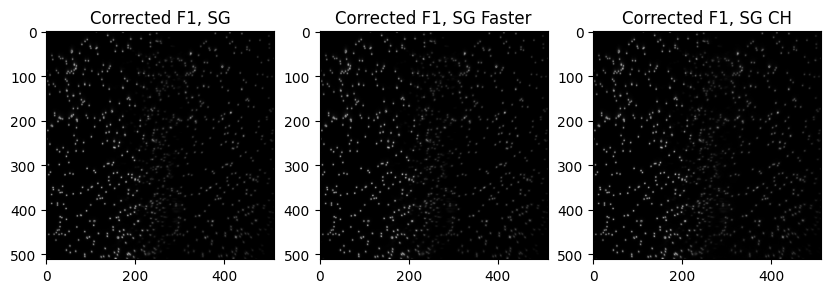

In [32]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
ax[0].imshow(corrected_frames_data[0], cmap='gray')
ax[0].set_title('Corrected F1, SG')

ax[1].imshow(corrected_frames_data_faster[0], cmap='gray')
ax[1].set_title('Corrected F1, SG Faster')

ax[2].imshow(corrected_frames_data_CH[0], cmap='gray')
ax[2].set_title('Corrected F1, SG CH')

plt.show()

# New Function that considers Chanels into background calculations!

In [33]:
def SG_background_subtraction(pma_file_path, input_array, radius, y_centre_arr, x_centre_arr, CH_consideration=False):
    frames_data = read_pma(pma_file_path) 
    height, width, _ = input_array.shape
    y_indices, x_indices = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
    filled_circle_mask = np.zeros((height, width), dtype=bool)

    if not CH_consideration:
        all_peaks_intensity = 0
        total_intensity = np.sum(input_array[:, :,2])
        num_of_peaks = len(y_centre_arr)
        num_of_frame_pixels = height * width

        num_of_peak_pixels = count_circle(radius) * num_of_peaks #each channel
        corrected_frames_data = []

        for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
            mask = (x_indices - x_centre) ** 2 + (y_indices - y_centre) ** 2 < radius ** 2
            filled_circle_mask|= mask
        
        all_peaks_intensity += np.sum(input_array[filled_circle_mask, 2])
        intensity_to_remove = ((total_intensity-all_peaks_intensity) // (num_of_frame_pixels-num_of_peak_pixels))
        for frame in frames_data: #frame is 1D
            frame = frame.astype(np.int16)
            frame = np.clip(frame - intensity_to_remove, 0, 255).astype(np.uint8)
            corrected_frames_data.append(frame)

    else: 
        all_peaks_intensity_CH1 = 0
        all_peaks_intensity_CH2 = 0

        total_intensity_CH1 = np.sum(input_array[:, :width//2,2])
        total_intensity_CH2 = np.sum(input_array[:, width//2:,2])
        num_of_peaks = len(y_centre_arr)//2 #this is in each channel
        num_of_frame_pixels = height*width//2

        num_of_peak_pixels = count_circle(radius) * num_of_peaks #each channel
        corrected_frames_data = []

        for y_centre, x_centre in zip(y_centre_arr, x_centre_arr):
            mask = (x_indices - x_centre) ** 2 + (y_indices - y_centre) ** 2 < radius ** 2
            filled_circle_mask|= mask

        # split the filled_circle_mask into two channels
        filled_circle_mask_CH1 = filled_circle_mask[:, :width//2]
        filled_circle_mask_CH2 = filled_circle_mask[:, width//2:]
            
        all_peaks_intensity_CH1 += np.sum(input_array[:, :width//2, 2][filled_circle_mask_CH1])
        all_peaks_intensity_CH2 += np.sum(input_array[:, width//2:, 2][filled_circle_mask_CH2])

        intensity_to_remove_CH1 = ((total_intensity_CH1-all_peaks_intensity_CH1) // (num_of_frame_pixels-num_of_peak_pixels)).astype(np.int16)
        intensity_to_remove_CH2 = ((total_intensity_CH2-all_peaks_intensity_CH2) // (num_of_frame_pixels-num_of_peak_pixels)).astype(np.int16)
    
        for frame in frames_data: #frame is 1D
            frame = frame.astype(np.int16)
            frame_CH1 = np.clip(frame[:,:width//2] - intensity_to_remove_CH1, 0, 255).astype(np.uint8)
            frame_CH2 = np.clip(frame[:,width//2:] - intensity_to_remove_CH2, 0, 255).astype(np.uint8)
            frame = np.concatenate((frame_CH1, frame_CH2), axis=1)
            corrected_frames_data.append(frame)

    return corrected_frames_data

In [34]:

frames_data_old = static_global_CH_background_subtraction(file_path, image_3d, 4, y_centres_hel1, x_centres_hel1)
print(f"Corrected Frames_data type: {type(frames_data_old)}")
print(f"Corrected Frames_data[0] shape: {frames_data_old[0].shape}")
print(f"Corrected Frames_data element type: {type(frames_data_old[0][0][0])}")

frames_data_new = SG_background_subtraction(file_path, image_3d, 4, y_centres_hel1, x_centres_hel1, CH_consideration=True)
print(f"Corrected Frames_data type: {type(frames_data_new)}")
print(f"Corrected Frames_data[0] shape: {frames_data_new[0].shape}")
print(f"Corrected Frames_data element type: {type(frames_data_new[0][0][0])}")



Image Size: 512 x 512
Corrected Frames_data type: <class 'list'>
Corrected Frames_data[0] shape: (512, 512)
Corrected Frames_data element type: <class 'numpy.uint8'>
Image Size: 512 x 512
Corrected Frames_data type: <class 'list'>
Corrected Frames_data[0] shape: (512, 512)
Corrected Frames_data element type: <class 'numpy.uint8'>


In [35]:
#Consider CH1 reduction
print(frames_data_old[300][454][31:39])
print(frames_data_new[300][454][31:39])

#Consider CH2 reduction
print(frames_data_old[300][454][287:295])
print(frames_data_new[300][454][287:295])

[ 2  4 21 53 50 19  3  1]
[ 2  4 21 53 50 19  3  1]
[17 18 13  7  5  5  8 10]
[17 18 13  7  5  5  8 10]
